# Solving Yashi with SAT

First, we need some dependencies and imports. This can be ignored.

In [2]:
%pip install python-sat
from pysat.solvers import Minisat22
from pysat.examples.rc2 import RC2
from pysat.formula import WCNFPlus

%pip install matplotlib
from matplotlib import pyplot

from itertools import combinations, product
import requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Edge detection

The first step is to detect the possible edges out of a set of nodes positions.
This is done by iterating through every pair of nodes and checking if they're valid. An edge is valid if its either horizonal or vertical, that is the two nodes are on the same row or column, and if there's no other node inbetween them.

In [3]:
def find_edges(nodes):
    def edge_exist(nodes, nsxy, nexy):
        nsx, nsy = nsxy
        nex, ney = nexy

        # the edge is vertical
        if nsx == nex and nsy != ney:
            # check that no other node is in between
            for nmx, nmy in nodes:
                if nmx == nsx and nsy < nmy < ney:
                    return False
            return True
        
        # the edge is horizontal
        if nsy == ney and nsx != nex:
            # check that no other node is in between
            for nmx, nmy in nodes:
                if nmy == nsy and nsx < nmx < nex:
                    return False
            return True
        
        return False
    
    for (i, nsxy), (j, nexy) in combinations(enumerate(nodes), 2):
        if edge_exist(nodes, nsxy, nexy):
            yield (i, j)

## Conflict detection

Once the set of possible edges has been found, the second step is finding out which of them are incompatible with each other.
This is also done by iterating through every possible edge pair and checking whether they conflict, that is they have different directions and both cross the constant coordinate of the other.

In [4]:
def find_conflicts(nodes, edges):
    def edges_conflict(nodes, edge1, edge2):
        s1, e1 = edge1
        s2, e2 = edge2
        
        s1x, s1y = nodes[s1]
        e1x, e1y = nodes[e1]
        s2x, s2y = nodes[s2]
        e2x, e2y = nodes[e2]

        # s1x < e1x is true only if edge1 is horizontal
        # s2y < e2y is true only if edge2 is vertical
        # the inclusion of s2x and s1y in the middle is true only if they cross
        if s1x < s2x < e1x and s2y < s1y < e2y:
            return True
        
        # Like above, but now edge1 is vertical and edge2 is horizontal
        if s2x < s1x < e2x and s1y < s2y < e1y:
            return True
        
        return False
    
    for (i, edge1), (j, edge2) in combinations(enumerate(edges), 2):
        if edges_conflict(nodes, edge1, edge2):
            yield (i, j)

## Variables

At this point we need to generate the SAT constraints, but the library used to solve them requires the variables to be integers. In this section we define a couple of methods for converting the 3 kind of variables used into integer ids. The variables used are:

- `var_edge` generates the integer ids for $e_i$, which represent whether the edge $i$ is selected or not;
- `var_directed_edge` generates the integer ids for $e^+_i$ and $e^-_i$, which represent the direction in which the edge $i$ is selected; these will be useful later for some kind of constraints;
- `var_under` generates the integer ids for $u_{ij}$, which represent whether the node $i$ stands under (not necessarily directly) the node $j$ in the final spanning tree.

In [23]:
# The first len(edges) variables represent whether an undirected edge is selected.
# These are directly encoded with the edge index (plus 1 to start from 1 instead of 0).
def var_edge(e):
    return 1 + e

# After the first len(edges) variables, the next 2*len(edges) variables
# represent whether the edge from ns to ne is selected in that specific direction.
# Note that an edge from ns to ne is expected to exist, or this will error.
# These are encoded sorted by edge index, which gets multiplied by 2 because there are two variables per edge.
def var_directed_edge(edges, ns, ne):
    # Edge nodes are always stored in order, to (ns, ne) may not exist in edges
    # if ns > ne. Using tuple(sorted((ns, ne))) solves this problem
    return 1 + len(edges) + 2 * edges.index(tuple(sorted((ns, ne)))) + (ns > ne)

# After the first len(edges)+2*len(edges), the next len(nodes)**2 variables
# represent whether a node ni is "under" a node nj in the solution tree.
# These are encoded like the index of a 2D matrix. 
def var_under(nodes, edges, ni, nj):
    return 1 + 3 * len(edges) + ni * len(nodes) + nj

## Constraints

The last important step is to actually generate the constraints. These are divided in 4 kinds:

### Constraints for conflicts

For each edge $i$ which conflict with edge $j$ we generate a constraint $\neg e_i \vee \neg e_j$.

In [25]:
def constraints_conflict(conflicts):
    for ei, ej in conflicts:
        # Two conflicting edges cannot be selected at the same time
        yield [-var_edge(ei), -var_edge(ej)]

### Constraints for correspondence between undirected and directed edges

A undirected edge is selected if and only if one of its corresponding directed edge is selected, that is for every edge $i$ we have $e_i \leftrightarrow e^+_i \vee e^-_i$, which gets expanded into $(\neg e_i \vee e^+_i \vee e^-_i) \land (e_i \vee \neg e^+_i) \land (e_i \vee \neg e^-_i)$.

Moreover an edge can only be selected in one direction, that is the two directions are mutually exclusive, and this can be expressed with $\neg e^+_i \vee \neg e^-_i$

In [26]:
def constraints_directed(edges):
    for e, (ns, ne) in enumerate(edges):
        ve = var_edge(e)
        vse = var_directed_edge(edges, ns, ne)
        ves = var_directed_edge(edges, ne, ns)
        # An undirected edge is selected iff one of its directed versions is selected
        yield [-ve, vse, ves]
        yield [ve, -vse]
        yield [ve, -ves]
        # Two corresponding directed edges cannot be selected at the same time
        yield [-vse, -ves]

### Constraints for the parent edges

We want the resulting graph to be a spanning tree and one of the ways to do this involves forcing it to have `len(nodes) - 1` edges. Doing this with an "exactly n" constraint will result in an exponential number of clauses though. Fortunately we also require the final graph to be a tree, which can simplify this a lot: in fact we can identify each edge as connecting a node to its parent in the tree, reducing the problem to an "exactly 1" constraint. To distinguish an edge that connects a child to its parent from one that connects the parent to the child, we use the edge direction, which is why we have variables for them.

Overall this reduces to the following clauses:

- $\neg e^+_i$ for all edges $i$ starting from the node $0$
- $e^+_{i_1} \vee e^+_{i_2} \vee ... \vee e^-_{j_1} \vee e^-_{j_2} \vee ...$ for all edges $i_1, ...$ starting from the node $k$ and edges $j_1, ...$ ending in node $k$, for $k \neq 0$
- $\neg e^\pm_x \vee \neg e^\pm_y$ for all $e^\pm_x$, $e^\pm_y$ present in the previous clause

In [27]:
def constraints_parent_edge(nodes, edges):
    # The root node 0 cannot have parent directed edges
    for ns, ne in edges:
        if ns == 0:
            yield [-var_directed_edge(edges, 0, ne)]

    # Every other node must have exactly one parent directed edge
    for n in range(1, len(nodes)):
        adj = [m for m in range(len(nodes)) if (n, m) in edges or (m, n) in edges]
        # At least one
        yield [var_directed_edge(edges, n, o) for o in adj]
        # At most one
        for m, o in combinations(adj, 2):
            yield [-var_directed_edge(edges, n, m), -var_directed_edge(edges, n, o)]

### Constraints for the "under" relation

We want the resulting graph to be acyclic, and the way we do this is by forcing a child node to be under a parent node. Since every node is connected to only one parent, in order to form a cycle the parent would have to be someone connected to its child or a child or it child and so on. If this were to happen they would be one under the other and that would form a contradiction, and thus a clause would break. Formally, we define the "under" relation as an irreflexive and transitive relation, and implied by the presence of a directed edge from a child to a parent.

Overall this reduces to the following clauses:

- $e^+_i \to u_{jk}$, which becomes $\neg e^+_i \vee u_jk$, if edge $i$ goes from node $j$ to node $k$;
- $e^-_i \to u_{jk}$, which becomes $\neg e^-_i \vee u_jk$, if edge $i$ goes from node $k$ to node $j$;
- $\neg u_{ii}$, to enforce irreflexivity;
- $u_{ij} \land u_{jk} \to u_{ik}$, which becomes $\neg u_{ij} \vee \neg u_{jk} \vee u_{ik}$, for all nodes $i$, $j$ and $k$, to enforce transitivity.

In [ ]:
def constraints_hierarchy(nodes, edges):
    for ns, ne in edges:
        # A parent directed edge implies a node is under its parent
        yield [-var_directed_edge(edges, ns, ne), var_under(nodes, edges, ns, ne)]
        yield [-var_directed_edge(edges, ne, ns), var_under(nodes, edges, ne, ns)]
        
    for n in range(len(nodes)):
        # The "under" relation is irreflexive: a node cannot be under itself
        yield [-var_under(nodes, edges, n, n)]

    for n, m, o in product(range(len(nodes)), repeat=3):
        # The "under" relation is transitive: if n is under m and m is under o then n is under o
        yield [-var_under(nodes, edges, n, m), -var_under(nodes, edges, m, o), var_under(nodes, edges, n, o)]

Finally we merge all the constraints in a single function.

In [28]:
def constraints(nodes, edges, conflicts):
    yield from constraints_conflict(conflicts)
    yield from constraints_directed(edges)
    yield from constraints_parent_edge(nodes, edges)
    yield from constraints_hierarchy(nodes, edges)

This is a small helper to plot the solution of a yashi game.

In [7]:
def plot_solution(nodes, edges, model):
    xs = [x for x, _ in nodes]
    ys = [y for _, y in nodes]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)

    pyplot.figure()
    pyplot.gca().set_aspect("equal", "box")
    pyplot.xticks(range(minx, maxx + 1))
    pyplot.yticks(range(miny, maxy + 1))
    pyplot.xlim(minx - 0.5, maxx + 0.5)
    pyplot.ylim(miny - 0.5, maxy + 0.5)
    pyplot.plot(xs, ys, "ok", linestyle='', markersize=7)

    for e in range(len(edges)):
        if var_edge(e) in model:
            ns, ne = edges[e]
            nsx, nsy = nodes[ns]
            nex, ney = nodes[ne]
            pyplot.plot((nsx, nex), (nsy, ney), "k")

This is the main entrypoint for solving a yashi game, given a list of node, each consisting of its position in the grid.

In [8]:
def yashi(nodes):
    nodes = sorted(nodes)
    edges = list(find_edges(nodes))
    conflicts = list(find_conflicts(nodes, edges))

    solver = Minisat22(bootstrap_with = constraints(nodes, edges, conflicts))

    if solver.solve():
        plot_solution(nodes, edges, solver.get_model())
    else:
        print("There's no solution")

This is the main entrypoint for solving a yashi game with the minimum length solution.

## Minimum-length solution

In order to find a minimum length solution we use Max-SAT to solve the same problem as before, keeping all the clauses as hard clauses, but adding one soft clause per edge with weight equal to the negation of its length. This makes it so that the weight of the interpretation will be the negation of the length of the solution, and maximing that will result in minimizing the length of the solution. 

In [9]:
def min_yashi(nodes):
    nodes = sorted(nodes)
    edges = list(find_edges(nodes))
    conflicts = find_conflicts(nodes, edges)

    # RC2 is a pythonsat solver for max sat
    solver = RC2(WCNFPlus(), solver="m22")

    # Manually add hard clauses because there's no `extend` or `bootstrap_with`
    for clause in constraints(nodes, edges, conflicts):
        solver.add_clause(clause)

    # Add the soft clauses for the edge lengths
    for e, (ns, ne) in enumerate(edges):
        nsx, nsy = nodes[ns]
        nex, ney = nodes[ne]
        weight = -(abs(nsx - nex) + abs(nsy - ney))
        solver.add_clause([var_edge(e)], weight=weight)

    model = solver.compute()
    if model:
        plot_solution(nodes, edges, model)
    else:
        print("There's no solution")

Helper function to extract the list of nodes from a `sumsumpuzzle.com` URL.

In [10]:
def sumsumpuzzle_nodes(url):
    page = requests.get(url).text
    grid = page.split("grid = [,\n")[1].split("];\n</script>")[0]
    for y, line in enumerate(reversed(grid.split("\n"))):
        for x, cell in enumerate(line.lstrip("[,").rstrip(",").rstrip("]").split(",")):
            if cell == "dot":
                yield (x+1, y+1)

## Examples

Examples of a solving some instances from `sumsumpuzzle.com`

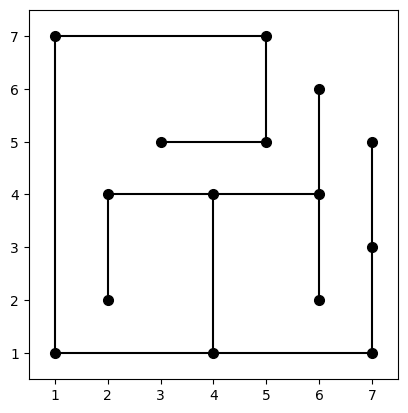

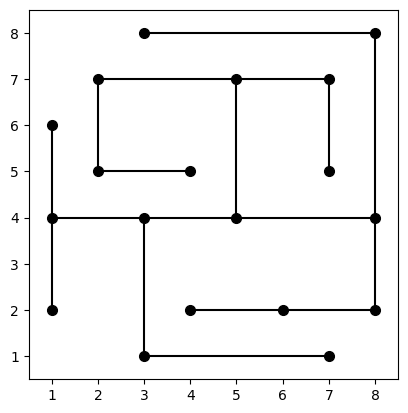

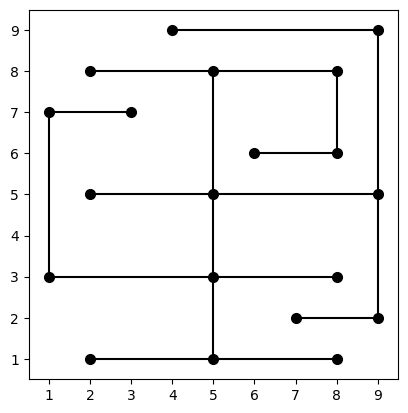

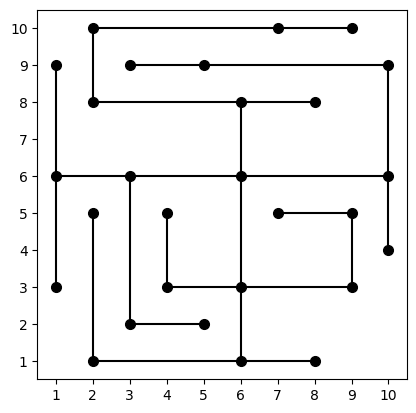

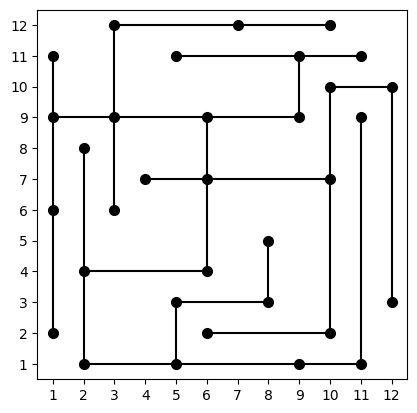

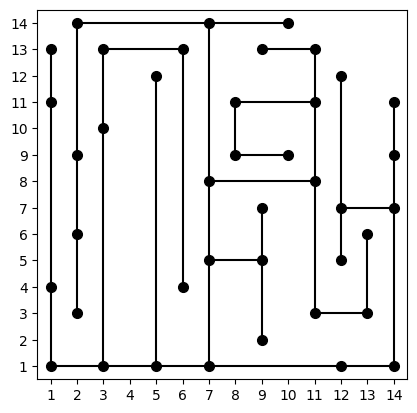

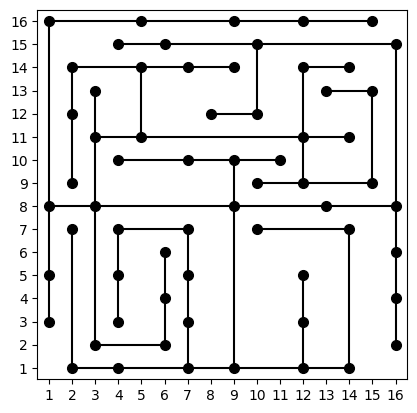

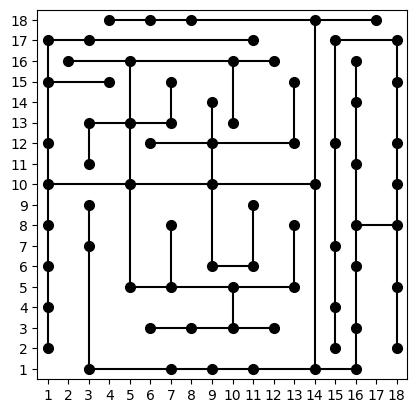

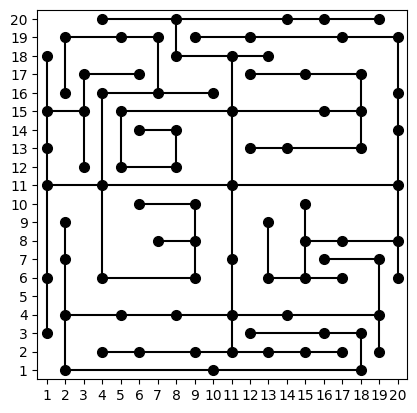

In [11]:
urls = [
    "http://www.sumsumpuzzle.com/Y201108_0707P.htm",
    "http://www.sumsumpuzzle.com/Y201108_0808P.htm",
    "http://www.sumsumpuzzle.com/Y201108_0909P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1010P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1212P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1414P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1616P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1818P.htm",
    "http://www.sumsumpuzzle.com/Y201108_2020P.htm",
]
for url in urls:
    yashi(sumsumpuzzle_nodes(url))

Example of `min_yashi` finding the minimum-length solution where `yashi` doesn't.

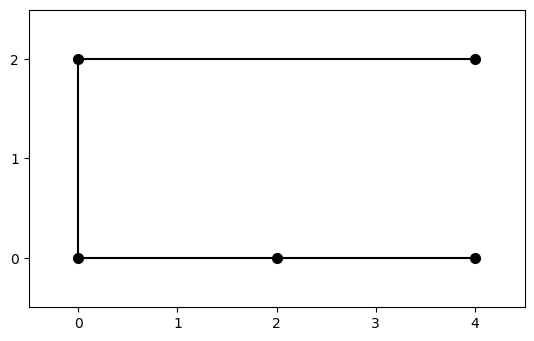

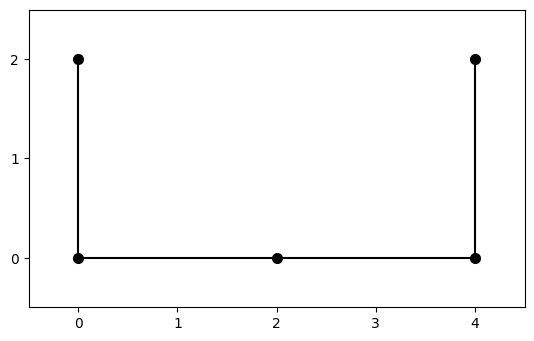

In [12]:
nodes = [(0, 2), (0, 0), (2, 0), (4, 0), (4, 2)]
yashi(nodes)
min_yashi(nodes)

Example of `min_yashi` with some instances from `sumsumpuzzle.com`. Note that on the commented out urls it takes too long.

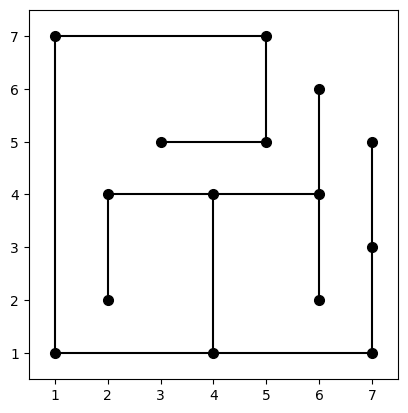

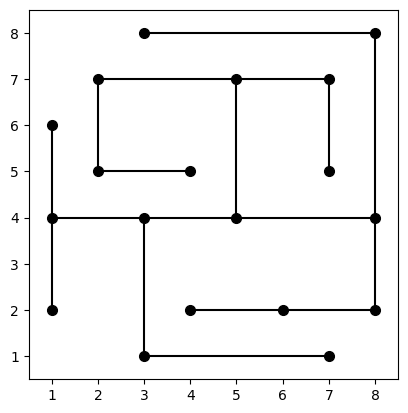

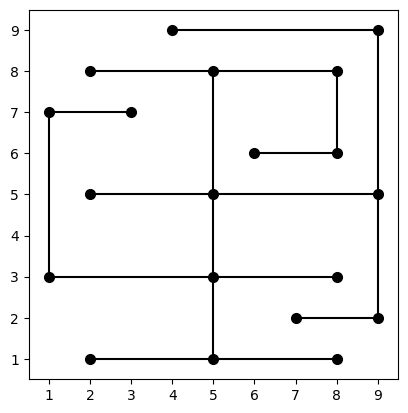

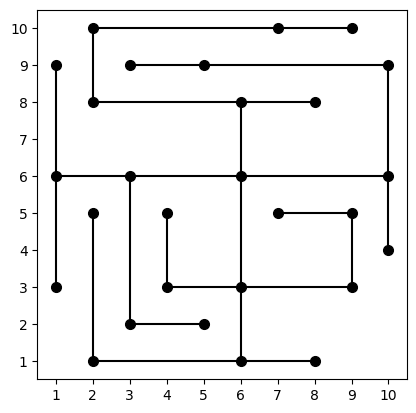

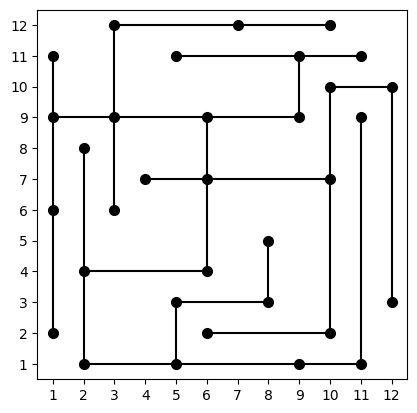

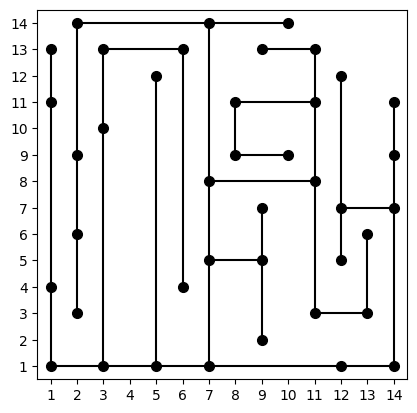

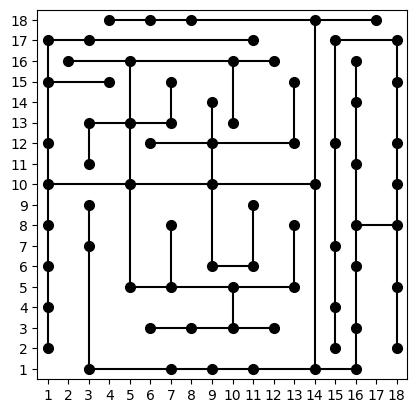

In [22]:
urls = [
    "http://www.sumsumpuzzle.com/Y201108_0707P.htm",
    "http://www.sumsumpuzzle.com/Y201108_0808P.htm",
    "http://www.sumsumpuzzle.com/Y201108_0909P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1010P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1212P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1414P.htm",
    # "http://www.sumsumpuzzle.com/Y201108_1616P.htm",
    "http://www.sumsumpuzzle.com/Y201108_1818P.htm",
    # "http://www.sumsumpuzzle.com/Y201108_2020P.htm",
]
for url in urls:
    min_yashi(sumsumpuzzle_nodes(url))